In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from preprocessor.api import clean


In [6]:
sotu_retweets = pd.read_csv("https://assets.datacamp.com/production/repositories/2161/datasets/51e79668580cdb86969c2c625172eaed2ded684a/sotu2018-rt.csv")

In [8]:
sotu_retweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   contributors                               0 non-null      float64
 1   coordinates                                0 non-null      float64
 2   created_at                                 2340 non-null   object 
 3   extended_entities                          283 non-null    object 
 4   favorite_count                             2340 non-null   int64  
 5   favorited                                  2340 non-null   bool   
 6   filter_level                               2340 non-null   object 
 7   geo                                        0 non-null      float64
 8   id                                         2340 non-null   int64  
 9   id_str                                     2340 non-null   int64  
 10  in_reply_to_screen_name 

In [11]:
sotu_retweets_Fox = sotu_retweets[(sotu_retweets["user-screen_name"] == "FoxNews") | (sotu_retweets["retweeted_status-user-screen_name"] == "FoxNews")]
#either the user tweeting or the user being retweeted is FoxNews

In [21]:
sotu_retweets_Fox[(sotu_retweets_Fox["user-screen_name"] == "FoxNews")].shape[0], sotu_retweets_Fox[(sotu_retweets_Fox["retweeted_status-user-screen_name"] == "FoxNews")].shape[0]
#FoxNews is the user screen name once, and 128 times the retweeted user screen name

(1, 128)

In [26]:
#Network analysis
G_rt = nx.from_pandas_edgelist( sotu_retweets_Fox, source ='retweeted_status-user-screen_name', target = 'user-screen_name', create_using = nx.DiGraph())
nx.info(G_rt)
#130 different users and 129 different connections between them (the user and retweetet user)

'DiGraph with 130 nodes and 129 edges'

In [28]:
G_rt_degree = pd.DataFrame(list(G_rt.degree()), columns = ['ID', 'deg'])
G_rt_degree 
#as expected fox news has a degree of 129, this means that 129 connections exist towards FoxNews
#The other users are completely unrelated to another

,ID,deg
0,FoxNews,129
1,coachfoster15,1
2,VoseJim,1
3,slewis8353,1
4,TravarL,1
...,...,...
125,TimTheTruckerCA,1
126,ggary59,1
127,Chelseax05,1
128,rob_radams20,1


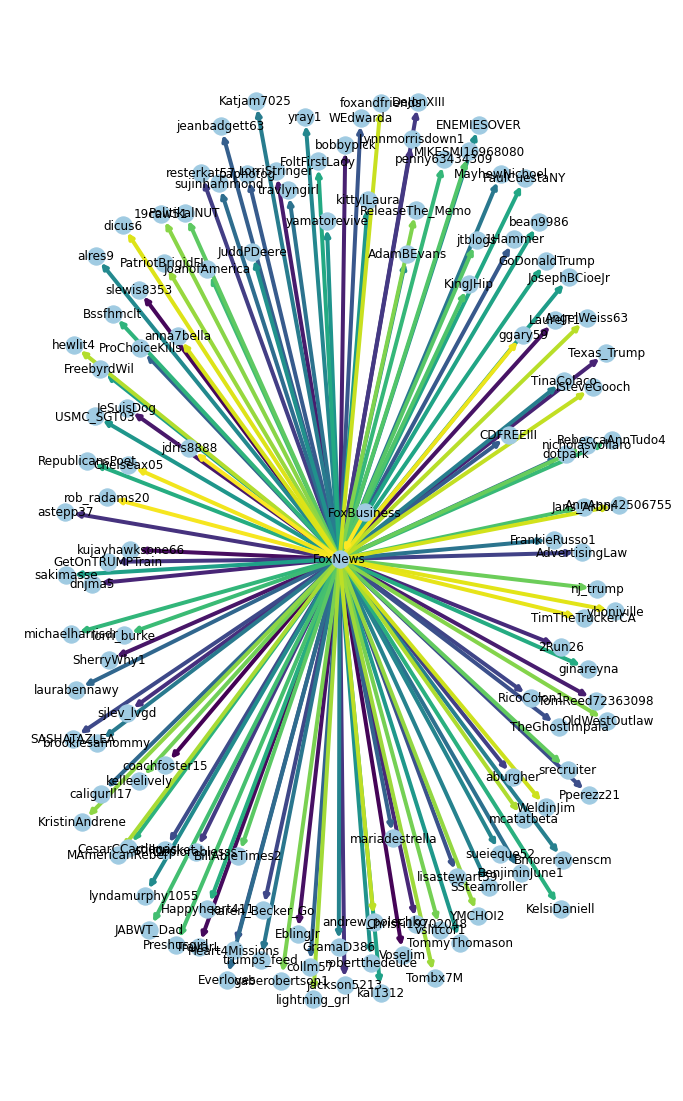

In [41]:
plt.figure(figsize=(12,20))  #set figure size
pos = nx.spring_layout(G_rt,k=0.2,iterations=20) #defines position of the nodes; k is "optimal distance between notes"; iterations will rerun to achieve best positions
#in this case the more iterations the more circular it will be
colours = range(129) #create 129 different colours
nx.draw_networkx(G_rt,pos,arrows=True, node_color='#A0CBE2', edge_color=colours, width=4, with_labels=True) #draws the network in our generated colours
plt.axis('off')
plt.show()
#notably, fox business is much closer to fox news than the others, this is because fox business is the only ingoing connection for fox news

In [43]:
#Network analysis on full dataset
G_rt_full = nx.from_pandas_edgelist(sotu_retweets, source ='retweeted_status-user-screen_name', target = 'user-screen_name', create_using = nx.DiGraph())
nx.info(G_rt_full)

'DiGraph with 2287 nodes and 2340 edges'

In [59]:
pd.DataFrame.from_dict(nx.in_degree_centrality(G_rt_full), orient = "index", columns = ['deg']).sort_values("deg", ascending= False).head(5)
#5 users with the most in degree centrality (retweeting most often)

,deg
nljac000,0.002187
aedaw9i,0.001750
CiAnDy3,0.001750
SteveJa39296543,0.001750
c5hardtop1999,0.001750


In [58]:
pd.DataFrame.from_dict(nx.out_degree_centrality(G_rt_full), orient = "index", columns = ['deg']).sort_values("deg", ascending= False).head(5)
#5 users with most out degree centrality (being retweetet most often)

,deg
FoxNews,0.055993
WhiteHouse,0.031059
ScottPresler,0.029746
TomiLahren,0.019685
KyleKulinski,0.017060


In [60]:
rt_centrality = nx.betweenness_centrality(G_rt_full)
pd.DataFrame.from_dict(rt_centrality, orient = "index", columns = ['deg']).sort_values("deg", ascending= False).head(5)
#the top 5 users in betweenness centrality, they connect different sub-networks / communities around them

,deg
FoxNews,0.000026
Public_Citizen,0.000009
ChristiChat,0.000005
guypbenson,0.000005
johncardillo,0.000004


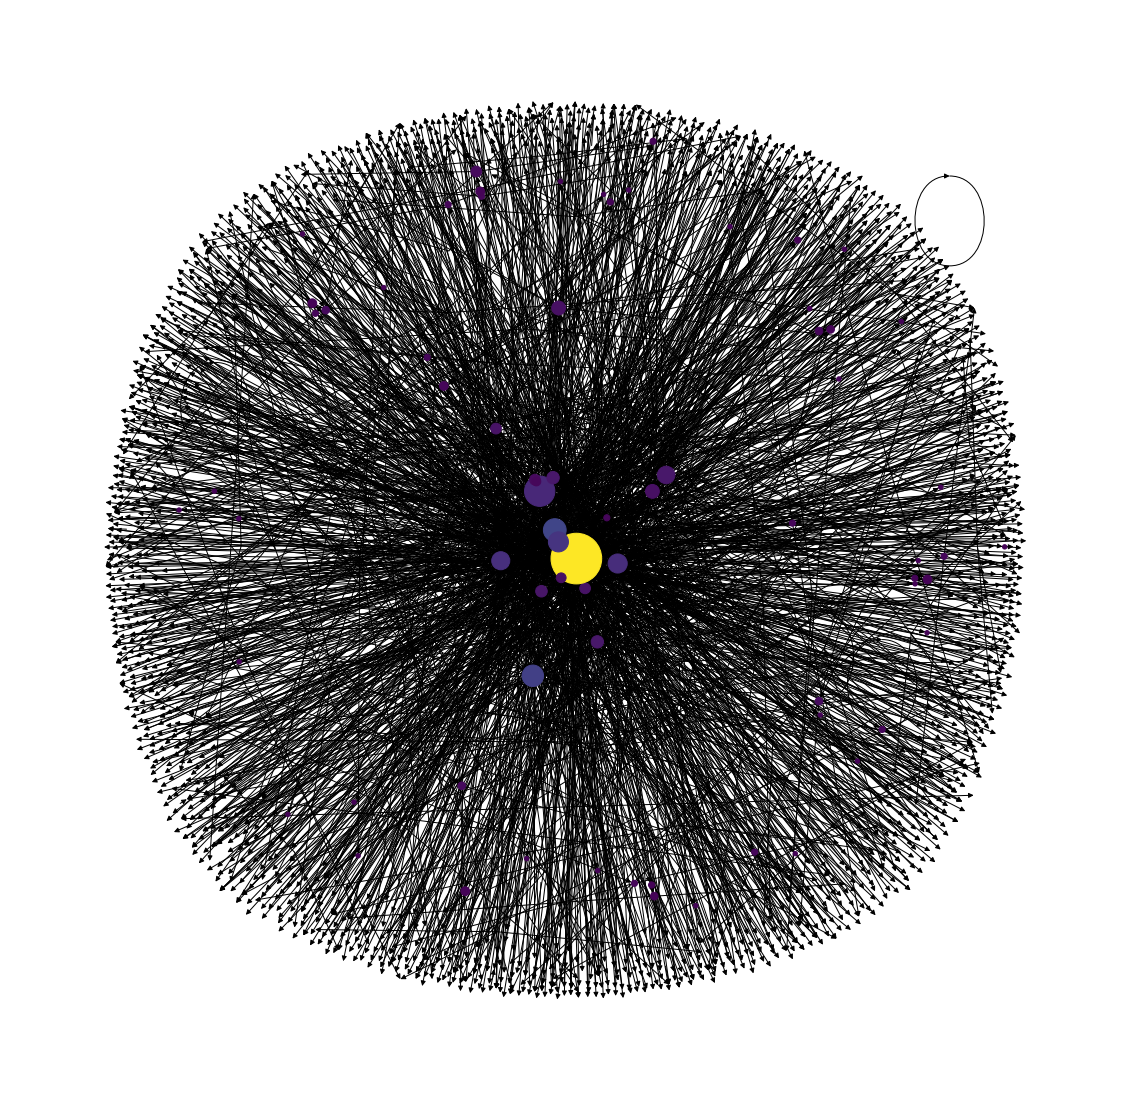

In [64]:
node_colour = [200000000* G_rt_full.out_degree(v) for v in G_rt_full] #the factor emphasizes the value of out degree
node_size = [v * 100000000 for v in rt_centrality.values()] #the factor emphasizes the value of betweenness centrality
plt.figure(figsize=(20,20))
nx.draw_networkx(G_rt_full, with_labels=False,node_color=node_colour,node_size=node_size) #plot network, node size depending on betweenness centrality, colour depending on out degree
plt.axis('off')
plt.show()
#we can see that the most inbetween central nodes are located near the middle and less around the edges, FoxNews still being the center of our Network